<a href="https://colab.research.google.com/github/alex-mat-s/Catboost-XAI/blob/main/Amazon_Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


## Amazon.com - Employee Access Challenge

### Data Description

The data consists of real historical data collected from 2010 & 2011.  Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees.

### Column Descriptions

**ACTION**	ACTION is 1 if the resource was approved, 0 if the resource was not

**RESOURCE**  An ID for each resource

**MGR_ID**	The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time

**ROLE_ROLLUP_1**	Company role grouping category id 1 (e.g. US Engineering)

**ROLE_ROLLUP_2**	Company role grouping category id 2 (e.g. US Retail)

**ROLE_DEPTNAME**	Company role department description (e.g. Retail)

**ROLE_TITLE**	Company role business title description (e.g. Senior Engineering Retail Manager)

**ROLE_FAMILY_DESC**	Company role family extended description (e.g. Retail Manager, Software Engineering)

**ROLE_FAMILY**	Company role family description (e.g. Retail Manager)

**ROLE_CODE**	Company role code; this code is unique to each role (e.g. Manager)

In [4]:
import pandas as pd
import catboost
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
#import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna.samplers import TPESampler
import joblib

In [5]:
sns.set_style("whitegrid")

In [6]:
def plot_metrics(model):
    # Plot metrics

    train_metrics_dict = model.get_evals_result()["learn"]
    valid_metrics_dict = model.get_evals_result()["validation"]

    train_logloss = train_metrics_dict["Logloss"]
    train_accuracy = train_metrics_dict["Accuracy:use_weights=true"]

    valid_logloss = valid_metrics_dict["Logloss"]
    valid_accuracy = valid_metrics_dict["Accuracy:use_weights=true"]
    valid_auc = valid_metrics_dict["AUC"]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    ax1.plot(train_accuracy, label="Train")
    ax1.plot(valid_accuracy, label="Validation")
    ax1.set_title("Accuracy")
    ax2.plot(train_logloss, label="Train")
    ax2.plot(valid_logloss, label="Validation")
    ax2.set_title("LogLoss")
    ax3.plot(valid_auc)
    ax3.set_title("AUC")

    ax1.legend()
    ax2.legend()

### Read Data

In [1]:
# Read from colab
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [7]:
# Read from local
PATH = "/content/drive/My Drive/ITMO/AMLT'23/Task2/"

df = pd.read_csv(PATH + "train.csv", sep='\t')

In [8]:
df.head(10)

ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   
5       0     45333   14561         117951         117952         118008   
6       1     25993   17227         117961         118343         123476   
7       1     19666    4209         117961         117969         118910   
8       1     31246     783         117961         118413         120584   
9       1     78766   56683         118079         118080         117878   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325  
5      118568            118568        19721     118570  
6      118980            301534       118295     118982  
7      126820            269034       118638     126822  
8      128230            302830         4673     128231  
9      117879            304519        19721     117880

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


As we can understand from the description, all variables in this dataset are categorical.

In [ ]:
# Remove duplicates
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.8 MB


In [ ]:
print("The number of classes:")
print("RESOURCE:", len(set(df.RESOURCE)))
print("ROLE_ROLLUP_1:", len(set(df.ROLE_ROLLUP_1)))
print("ROLE_ROLLUP_2:", len(set(df.ROLE_ROLLUP_2)))
print("ROLE_DEPTNAME:", len(set(df.ROLE_DEPTNAME)))
print("ROLE_TITLE:", len(set(df.ROLE_TITLE)))
print("ROLE_FAMILY_DESC:", len(set(df.ROLE_FAMILY_DESC)))
print("ROLE_FAMILY:", len(set(df.ROLE_FAMILY)))
print("ROLE_CODE:", len(set(df.ROLE_CODE)))

The number of classes:
RESOURCE: 7518
ROLE_ROLLUP_1: 128
ROLE_ROLLUP_2: 177
ROLE_DEPTNAME: 449
ROLE_TITLE: 343
ROLE_FAMILY_DESC: 2358
ROLE_FAMILY: 67
ROLE_CODE: 343


<Axes: xlabel='ACTION', ylabel='count'>

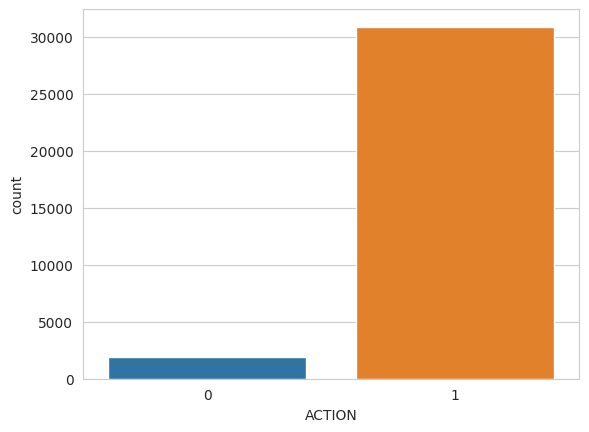

In [ ]:
sns.countplot(x='ACTION',
              data=df
             )

As we can see from the picture, the classes are extremely imbalanced. It is important to use one of the methods of weighing the class.

### Dataset Preparation

In [10]:
# Separate the target and features
X = df.drop("ACTION", axis=1)
y = df["ACTION"]

# Extract indexes of categorical features
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


### Fit the Model

In [11]:
# Split the data to train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1234)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=1234)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Valid size:", X_valid.shape)

Train size: (26215, 9)
Test size: (3277, 9)
Valid size: (3277, 9)


In [ ]:
feature_names = list(X_train.columns)

train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features)
test_pool = Pool(X_test, feature_names=feature_names, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, feature_names=feature_names, cat_features=cat_features)

#### Class Weighting

In [ ]:
# Getting Class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
# Fit the model
model_balanced = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    custom_loss=['AUC', 'Accuracy'],
    od_type='Iter',
    od_wait=20,
    class_weights=class_weights,
    verbose=False
)

print("Model is fitted:", model_balanced.is_fitted())
print("Model params:", model_balanced.get_params())

Model is fitted: False
Model params: {'iterations': 2000, 'learning_rate': 0.01, 'od_wait': 20, 'od_type': 'Iter', 'verbose': False, 'class_weights': {0: 8.646108179419524, 1: 0.530689501599255}, 'custom_loss': ['AUC', 'Accuracy']}


In [ ]:
model_balanced.fit(
    train_pool,
    eval_set=valid_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

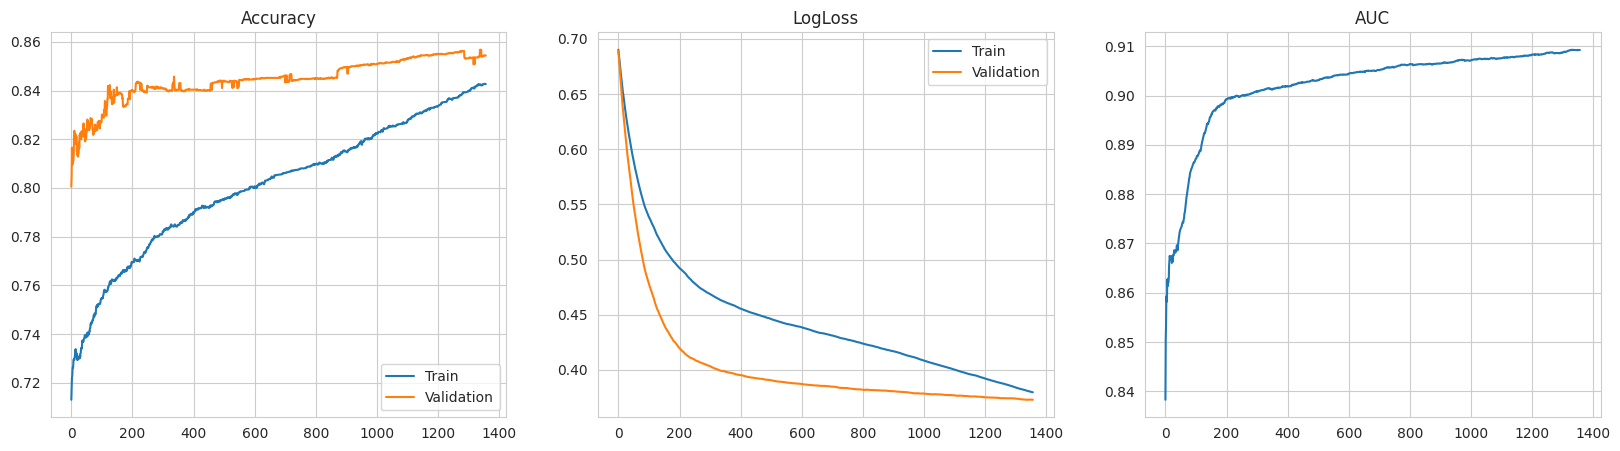

In [ ]:
plot_metrics(model_balanced)

In [ ]:
y_pred_balanced = model_balanced.predict(test_pool)

print("AUC:", roc_auc_score(y_test, y_pred_balanced))

AUC: 0.8191624137581996


In [ ]:
model_balanced.save_model(PATH + "model_balanced")

### Hyper Parameter tuning with Optuna

In [ ]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 800, 2500),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False,
        class_weights=class_weights,
        metric_period=50
    )
    print(trial.params.items())

    model.fit(train_pool)
    y_pred = model.predict(test_pool)

    return roc_auc_score(y_test, y_pred)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

dict_items([('iterations', 1509), ('learning_rate', 0.027583475549166746), ('depth', 4), ('l2_leaf_reg', 1.0551779964424746e-05), ('bootstrap_type', 'Bayesian'), ('random_strength', 2.0931628460945333e-07), ('bagging_temperature', 0.923385947687978), ('od_type', 'Iter'), ('od_wait', 26)])
dict_items([('iterations', 1716), ('learning_rate', 0.006892694481137703), ('depth', 7), ('l2_leaf_reg', 1.10795595820296e-06), ('bootstrap_type', 'Bayesian'), ('random_strength', 0.7999391045172093), ('bagging_temperature', 0.27387593197926163), ('od_type', 'IncToDec'), ('od_wait', 32)])
dict_items([('iterations', 1038), ('learning_rate', 0.002490020818620744), ('depth', 8), ('l2_leaf_reg', 48.15215820395775), ('bootstrap_type', 'Bayesian'), ('random_strength', 6.6193844201488494e-06), ('bagging_temperature', 6.923226156693141), ('od_type', 'Iter'), ('od_wait', 13)])
dict_items([('iterations', 866), ('learning_rate', 0.002186053765545967), ('depth', 8), ('l2_leaf_reg', 9.62649829692002e-08), ('bootst

In [ ]:
joblib.dump(study, PATH + "study.pkl")

["/content/drive/My Drive/ITMO/AMLT'23/Task2/study.pkl"]

In [ ]:
study = joblib.load(PATH + "study.pkl")

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.8279784236321307
  Params: 
    iterations: 1775
    learning_rate: 0.008496695783602586
    depth: 4
    l2_leaf_reg: 0.008389476455001573
    bootstrap_type: Bayesian
    random_strength: 3.2304954420993406e-07
    bagging_temperature: 0.286690638962948
    od_type: IncToDec
    od_wait: 31


In [ ]:
model_opt = catboost.CatBoostClassifier(
    **trial.params,
    custom_loss=['AUC', 'Accuracy'],
    class_weights=class_weights,
    verbose=False)

model_opt.fit(
    train_pool,
    eval_set=valid_pool
)
y_pred = model_opt.predict(test_pool)

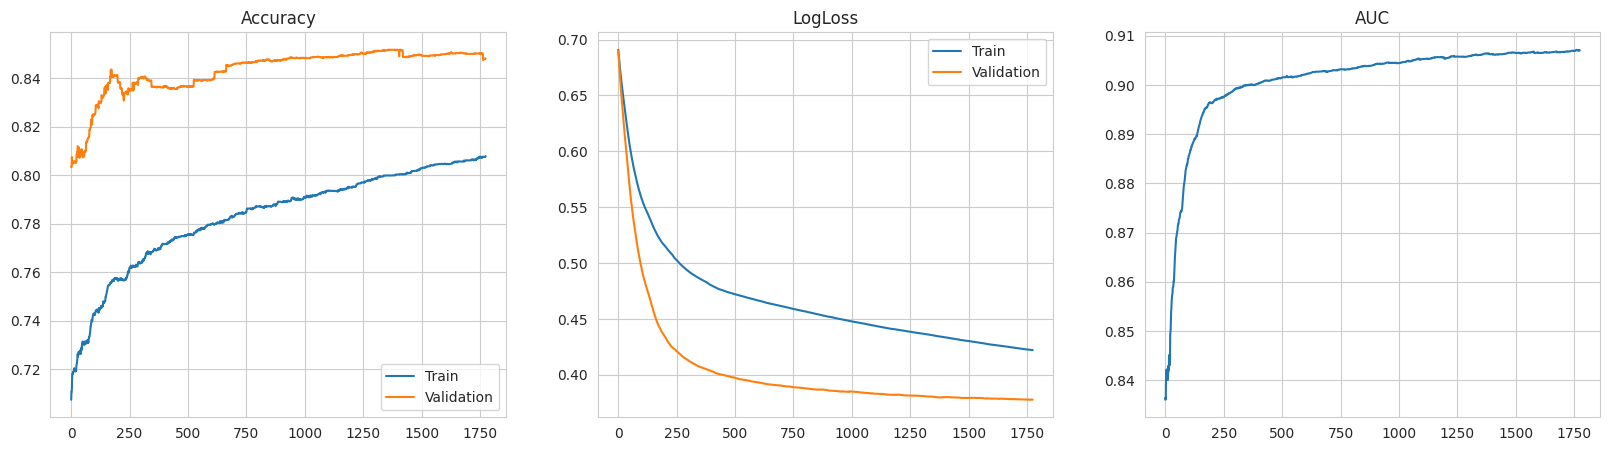

In [ ]:
plot_metrics(model_opt)

In [ ]:
y_pred_opt = model_opt.predict(test_pool)

print("AUC:", roc_auc_score(y_test, y_pred_opt))

AUC: 0.8279784236321307


In [ ]:
model_opt.save_model(PATH + "model_opt")

In [ ]:
model_opt = CatBoostClassifier()      # parameters not required.
model_opt.load_model(PATH + 'model_opt')

y_pred_opt = model_opt.predict(test_pool)

### Feature importance

### eli5

Permutation importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
perm = PermutationImportance(model_opt, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names=X_valid.columns.tolist())

The values towards the top are the most important features (RESOURCE, ROLE_DEPTNAME), and those towards the bottom matter least (ROLE_CODE, ROLE_ROLLUP_1).

The ID of the resource (in other words the resource that the employee wants to access) and the company role departmnet description directly affect the outcome of the decision.



### SHAP

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model_opt)
shap_values = explainer.shap_values(Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features))

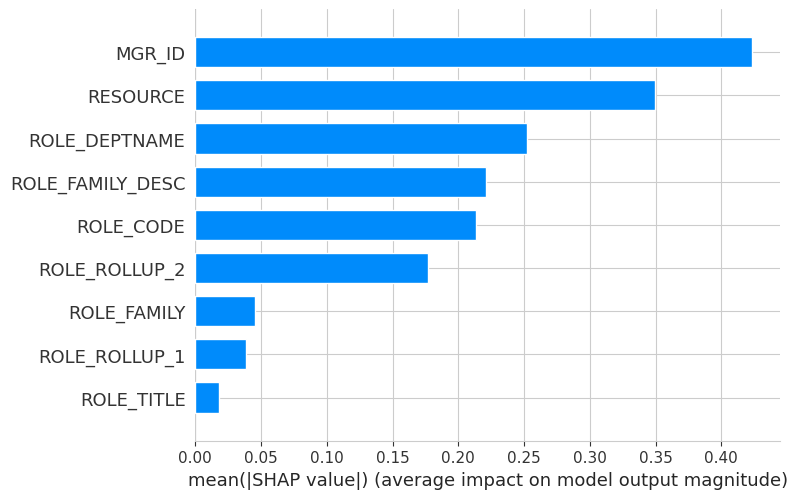

In [ ]:
# Feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

The most important features in this model are MGR_ID, RESOURCE and ROLE_DEPARTNAME (almost similar to the results obtained with permutation importance analysis) while the least features are ROLE_TITLE, ROLE_FAMILY, ROLE_ROLLUP_1.

Let's analyze it more deeply.


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

**Row 1** output is higher than the model baseline. This means the row would be predicted as being 1. As we can see all features has positive impact on the output. This can be interpreted as follows: all the features increase the likelihood that the employee will be granted access rights. ROLE_DEPTNAME, ROLE_CODE, ROLE_FAMILY_DESC have the largest impact, at the same time there are no features that would have opposite effect.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:])

**Row 10** output is lower than the baseline. MGR_ID and ROLE_FAMILY_DESC are gaving a significant negative impact on the output. ROLW_DEPTNAME gives a minor positive contribution.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[97,:], X_train.iloc[97,:])

Row 97 output is lower than the baseline. MGR_ID and ROLE_FAMILY_DESC again are gaving a significant negative impact on the output. RESOURCE gives a minor positive contribution.

In [ ]:
# Get information on 50 samples at the same time
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0:300,:], X_train.iloc[0:300,:])

The default visualization (sample order by similarity i.e putting the employees having the most similar features together) shows following model prediction pattern decision:
- In most cases, there are more features that give a positive contribution (this confirms the imbalance of classes)


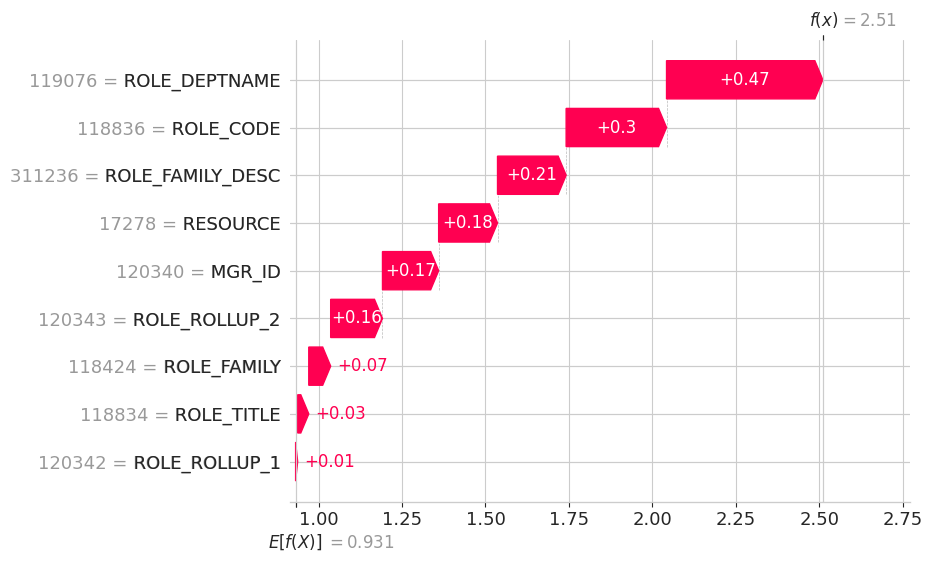

In [ ]:
shap.plots.waterfall(explainer(X_train)[1])

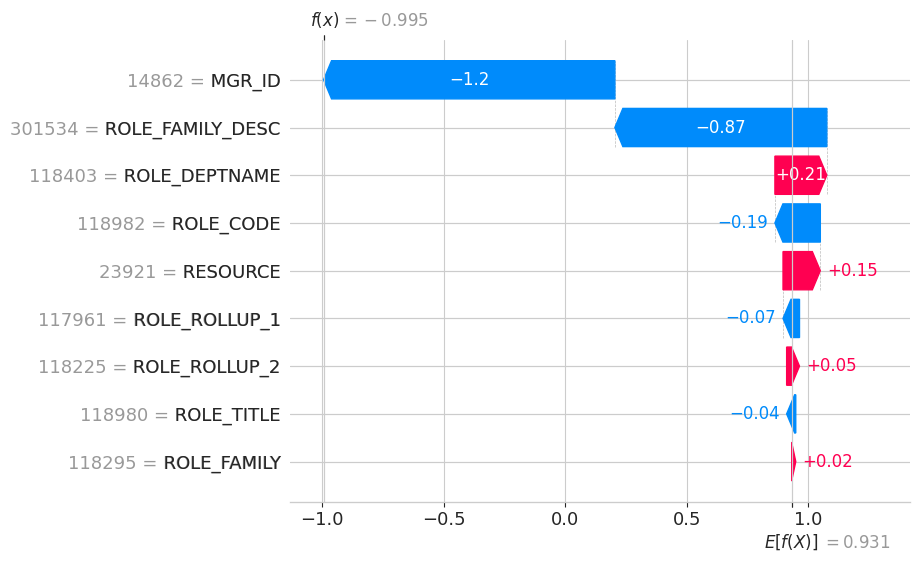

In [ ]:
shap.plots.waterfall(explainer(X_train)[10])

With waterfall we get the same reaults as for force_plot, but in more detail.

From all shaps diagrams we can conclude that features ROLE_TITLE, ROLE_FAMILY and ROLE_ROLLUP_1 do not have a big contribution to the model.

### LIME

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
from lime import lime_tabular

In [ ]:
# Create a wrapper
class catboost_predict_proba_wrapper:
    def __init__(self, model, column_names, list_cat_feat):
        self.model = model
        self.list_cat_feat = list_cat_feat
        self.column_names = column_names

    def predict_proba(self, this_array):
        shape_tuple = np.shape(this_array)
        if len(shape_tuple) == 1:
            this_array = this_array.reshape(1,-1)
        this_array = this_array.astype(int)

        self.pandas_df = pd.DataFrame(data=this_array,columns=self.column_names)

        self.data_pool = catboost.Pool(self.pandas_df,
                                       feature_names=self.column_names,
                                       cat_features=self.list_cat_feat)
        self.predictions = self.model.predict_proba(self.data_pool)
        return self.predictions

In [ ]:
explainer_lime = lime_tabular.LimeTabularExplainer(X_train.values,
                                                   class_names=['DENIED','APPROVED'],
                                                   feature_names=list(X_train.columns),
                                                   categorical_features=cat_features,
                                                   categorical_names=list(X_train.columns),
                                                   kernel_width=3
                                                  )

In [ ]:
# Create wrapper for the model using the defined class
class_names_dict = {0:'DENIED', 1:'APPROVED'}
cat_wrapper = catboost_predict_proba_wrapper(model_opt, list(X_train.columns), cat_features)

In [ ]:
print("Predicted:", y_pred_opt[1])
print("Real:", y_test.iloc[1])

Predicted: 1
Real: 1


In [ ]:
exp = explainer_lime.explain_instance(X_test.iloc[1].values.ravel(), cat_wrapper.predict_proba,num_features=9)
exp.show_in_notebook(show_all=True,show_predicted_value=True,show_table=True)

Here we explain the decisions behind the predictions for the third test vector by displaying the top features which contributed towards the said model’s prediction.

We can see the colors blue and orange, depicting negative and positive associations, respectively.

In this case, the model is not wrong. In the diagram, we can see that almost all features except ROLE_ROLLUP_N make a positive contribution. The most important in this case are also MG_IR, RESOURCE, ROLE_CODE. We can also assume that the ROLE_ROLLUP_1, ROLE_FAMILY and ROLE_TITLE features do not affect the final prediction so much.

In [ ]:
print("Predicted:", y_pred_opt[43])
print("Real:", y_test.iloc[43])

Predicted: 0
Real: 0


In [ ]:
exp = explainer_lime.explain_instance(X_test.iloc[43].values.ravel(), cat_wrapper.predict_proba,num_features=9)
exp.show_in_notebook(show_all=True,show_predicted_value=True,show_table=True)

According to this figure we can conclude, that almost all feature have negative contribution to the final prediction. And features ROLE_TITLE, ROLE_ROLLUP_1, ROLE_FAMILY does not affect the prediction so much as to shift it in a positive direction.

In [ ]:
print("Predicted:", y_pred_opt[0])
print("Real:", y_test.iloc[0])

Predicted: 0
Real: 1


In [ ]:
exp = explainer_lime.explain_instance(X_test.iloc[0].values.ravel(), cat_wrapper.predict_proba,num_features=9)
exp.show_in_notebook(show_all=True,show_predicted_value=True,show_table=True)

In this example, the model is wrong, and we see that many features have a negative contribution. In this example, removing the ROLE_ROLLUP_1, ROLE_TITLE and ROLE_FAMILY features is unlikely to change the situation, since we see that their contribution is not so large

In [ ]:
# Let's try remove most unimportant features: ROLE_FAMILY, ROLE_ROLLUP_1, ROLE_TITLE
new_X_train = pd.concat([X_train, X_valid])
new_y_train = pd.concat([y_train, y_valid])

new_X_train = new_X_train.drop(["ROLE_ROLLUP_1", "ROLE_TITLE", "ROLE_FAMILY"], axis=1)
new_X_test = X_test.drop(["ROLE_ROLLUP_1", "ROLE_TITLE", "ROLE_FAMILY"], axis=1)

# Split the data to train and validation
new_X_train, new_X_valid, new_y_train, new_y_valid = train_test_split(new_X_train, new_y_train,
                                                                      train_size=0.8, random_state=1234)

print("Train size:", new_X_train.shape)
print("Valid size:", new_X_valid.shape)

# Extract indexes of categorical features
new_cat_features = list(range(0, new_X_train.shape[1]))
print(new_cat_features)

new_feature_names = list(new_X_train.columns)

new_train_pool = Pool(new_X_train, new_y_train, feature_names=new_feature_names, cat_features=new_cat_features)
new_test_pool = Pool(new_X_test, feature_names=new_feature_names, cat_features=new_cat_features)
new_valid_pool = Pool(new_X_valid, new_y_valid, feature_names=new_feature_names, cat_features=new_cat_features)

Train size: (23593, 6)
Valid size: (5899, 6)
[0, 1, 2, 3, 4, 5]


In [ ]:
# Getting Class weights
new_classes = np.unique(new_y_train)
new_weights = compute_class_weight(class_weight='balanced', classes=new_classes, y=new_y_train)
new_class_weights = dict(zip(new_classes, new_weights))
new_class_weights

{0: 8.731680236861584, 1: 0.5303704702814495}

In [ ]:
new_model_opt = catboost.CatBoostClassifier(
    **trial.params,
    custom_loss=['AUC', 'Accuracy'],
    class_weights=new_class_weights,
    verbose=False)

new_model_opt.fit(
    new_train_pool,
    eval_set=new_valid_pool
)
new_y_pred = new_model_opt.predict(new_test_pool)

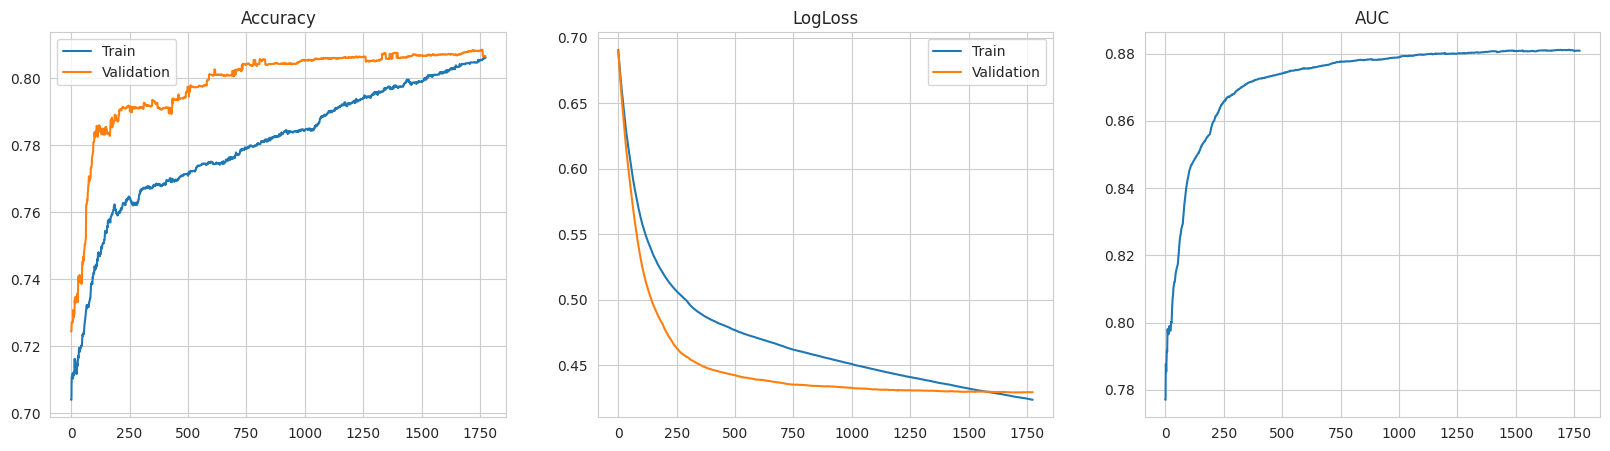

In [ ]:
plot_metrics(new_model_opt)

In [ ]:
new_y_pred = new_model_opt.predict(new_test_pool)

print("AUC:", roc_auc_score(y_test, new_y_pred))

AUC: 0.8006651189671555


In [18]:
new_y_pred = new_model_opt.predict(new_test_pool)

print("AUC:", roc_auc_score(y_test, new_y_pred))

AUC: 0.8007304227439994


### Conclusion
**Data and Features**

The data is a set of categorical features, the data is highly unbalanced and class weighing was used for better training. As a result of Feature Importance analysis, it turned out that "ROLE_ROLLUP_1", "ROLE_TITLE", "ROLE_FAMILY" have the least importance. An attempt was made to delete these columns and train the model on an incomplete set of features. This trick showed an AUC on the test less than 0.02 compared to the optimized model. This means that for some samples, these features are significant when predicting the class. The most significant for making a decision are: the EMPLOYEE ID of the manager, the resource to which the employee requests access and the department in which the employee works.


**Model**

To predict the status of an application for access to a resource, the CatBoost model was chosen, since it works perfectly when working with categorical variables. As a result of applying the Class Weighing method, as well as optimizing hyperparameters using optuna, it was possible to achieve AUC = 0.828, which is a pretty good result.